**This is example of how to trace model with jit and export it to the onnx**

In [1]:
from rl_games.torch_runner import Runner
import ray
import yaml
import torch
import matplotlib.pyplot as plt
import gym
from IPython import display
import numpy as np
import onnx
import onnxruntime as ort
%matplotlib inline

/home/viktorm/anaconda3/envs/warp39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/viktorm/anaconda3/envs/warp39/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
ray.init(object_store_memory=1024*1024*1000)

/home/viktorm/anaconda3/envs/warp39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '10.0.0.138', 'raylet_ip_address': '10.0.0.138', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-09-17_09-48-58_057211_671339/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-09-17_09-48-58_057211_671339/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-09-17_09-48-58_057211_671339', 'metrics_export_port': 47701, 'gcs_address': '10.0.0.138:36564', 'address': '10.0.0.138:36564', 'node_id': 'd24c72eb17281ff97ee050e4e0f9a718b397ba93129c09a20798ac27'})

In [3]:
config_name = '../rl_games/configs/ppo_cartpole.yaml'

In [4]:
with open(config_name, 'r') as stream:
    config = yaml.safe_load(stream)
    config['params']['config']['normalize_input'] = True
    config['params']['config']['max_epochs'] = 1000
    config['params']['config']['full_experiment_name'] = 'cartpole_onnx'
runner = Runner()
runner.load(config)
runner.run({
    'train': True,
})

self.seed = 1663433339
Started to train
Exact experiment name requested from command line: cartpole_onnx
current training device: cuda
build mlp: 4
build mlp: 4
RunningMeanStd:  (4,)


/home/viktorm/anaconda3/envs/warp39/lib/python3.9/site-packages/rl_games/common/experience.py:341: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tensor_dict['actions'] = self._create_tensor_from_space(gym.spaces.Box(low=0, high=1,shape=self.actions_shape, dtype=np.long), obs_base_shape)


fps step: 3632 fps step and policy inference: 601 fps total: 529 epoch: 1/1000
fps step: 3347 fps step and policy inference: 2417 fps total: 1514 epoch: 2/1000
fps step: 3284 fps step and policy inference: 2420 fps total: 1591 epoch: 3/1000
fps step: 3724 fps step and policy inference: 2634 fps total: 1644 epoch: 4/1000
fps step: 3716 fps step and policy inference: 2657 fps total: 1656 epoch: 5/1000
fps step: 3673 fps step and policy inference: 2637 fps total: 1634 epoch: 6/1000
fps step: 3669 fps step and policy inference: 2615 fps total: 1663 epoch: 7/1000
fps step: 3794 fps step and policy inference: 2727 fps total: 1677 epoch: 8/1000
fps step: 3505 fps step and policy inference: 2545 fps total: 1586 epoch: 9/1000
fps step: 3724 fps step and policy inference: 2661 fps total: 1665 epoch: 10/1000
saving next best rewards:  [23.410429]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3644 fps step and policy inference: 2650 fps total: 1653 epoch: 11/1000
sav

fps step: 3746 fps step and policy inference: 2716 fps total: 1693 epoch: 51/1000
saving next best rewards:  [84.74311]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 2822 fps step and policy inference: 2142 fps total: 1457 epoch: 52/1000
fps step: 3598 fps step and policy inference: 2643 fps total: 1661 epoch: 53/1000
fps step: 3714 fps step and policy inference: 2693 fps total: 1708 epoch: 54/1000
saving next best rewards:  [85.68365]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3728 fps step and policy inference: 2757 fps total: 1665 epoch: 55/1000
saving next best rewards:  [90.959694]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3674 fps step and policy inference: 2689 fps total: 1708 epoch: 56/1000
saving next best rewards:  [92.041176]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3745 fps step and policy inference: 2701 fps total: 1694 epoch: 57/1000
savi

fps step: 3770 fps step and policy inference: 2720 fps total: 1697 epoch: 111/1000
fps step: 3669 fps step and policy inference: 2665 fps total: 1676 epoch: 112/1000
fps step: 3681 fps step and policy inference: 2644 fps total: 1661 epoch: 113/1000
fps step: 3718 fps step and policy inference: 2701 fps total: 1685 epoch: 114/1000
fps step: 3661 fps step and policy inference: 2651 fps total: 1633 epoch: 115/1000
fps step: 3452 fps step and policy inference: 2533 fps total: 1611 epoch: 116/1000
fps step: 3500 fps step and policy inference: 2590 fps total: 1644 epoch: 117/1000
fps step: 3725 fps step and policy inference: 2702 fps total: 1686 epoch: 118/1000
fps step: 3616 fps step and policy inference: 2657 fps total: 1650 epoch: 119/1000
fps step: 3659 fps step and policy inference: 2674 fps total: 1652 epoch: 120/1000
fps step: 3695 fps step and policy inference: 2671 fps total: 1664 epoch: 121/1000
fps step: 3414 fps step and policy inference: 2513 fps total: 1612 epoch: 122/1000
fps 

fps step: 3661 fps step and policy inference: 2663 fps total: 1649 epoch: 210/1000
fps step: 3475 fps step and policy inference: 2521 fps total: 1604 epoch: 211/1000
fps step: 3608 fps step and policy inference: 2650 fps total: 1668 epoch: 212/1000
fps step: 3743 fps step and policy inference: 2726 fps total: 1676 epoch: 213/1000
fps step: 3548 fps step and policy inference: 2589 fps total: 1632 epoch: 214/1000
fps step: 3700 fps step and policy inference: 2724 fps total: 1695 epoch: 215/1000
saving next best rewards:  [132.31993]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3703 fps step and policy inference: 2697 fps total: 1667 epoch: 216/1000
saving next best rewards:  [133.52672]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3495 fps step and policy inference: 2565 fps total: 1633 epoch: 217/1000
fps step: 3670 fps step and policy inference: 2675 fps total: 1657 epoch: 218/1000
saving next best rewards:  [134.78241]
=>

fps step: 3692 fps step and policy inference: 2687 fps total: 1656 epoch: 270/1000
fps step: 3737 fps step and policy inference: 2689 fps total: 1671 epoch: 271/1000
fps step: 3562 fps step and policy inference: 2592 fps total: 1641 epoch: 272/1000
fps step: 3758 fps step and policy inference: 2735 fps total: 1705 epoch: 273/1000
fps step: 3488 fps step and policy inference: 2529 fps total: 1608 epoch: 274/1000
fps step: 3682 fps step and policy inference: 2635 fps total: 1647 epoch: 275/1000
fps step: 3735 fps step and policy inference: 2742 fps total: 1678 epoch: 276/1000
fps step: 3521 fps step and policy inference: 2611 fps total: 1619 epoch: 277/1000
fps step: 3697 fps step and policy inference: 2675 fps total: 1684 epoch: 278/1000
fps step: 3642 fps step and policy inference: 2642 fps total: 1643 epoch: 279/1000
fps step: 2952 fps step and policy inference: 2236 fps total: 1502 epoch: 280/1000
fps step: 3783 fps step and policy inference: 2746 fps total: 1730 epoch: 281/1000
fps 

fps step: 3525 fps step and policy inference: 2578 fps total: 1618 epoch: 345/1000
saving next best rewards:  [233.17752]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3476 fps step and policy inference: 2558 fps total: 1601 epoch: 346/1000
saving next best rewards:  [234.35574]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3683 fps step and policy inference: 2675 fps total: 1625 epoch: 347/1000
fps step: 3584 fps step and policy inference: 2589 fps total: 1603 epoch: 348/1000
saving next best rewards:  [235.66248]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3570 fps step and policy inference: 2561 fps total: 1547 epoch: 349/1000
saving next best rewards:  [236.82614]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3377 fps step and policy inference: 2489 fps total: 1577 epoch: 350/1000
saving next best rewards:  [239.45787]
=> saving checkpoint 'runs/cartpole_onn

fps step: 3633 fps step and policy inference: 2626 fps total: 1679 epoch: 396/1000
fps step: 3330 fps step and policy inference: 2437 fps total: 1540 epoch: 397/1000
saving next best rewards:  [311.49023]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3474 fps step and policy inference: 2553 fps total: 1560 epoch: 398/1000
saving next best rewards:  [317.08914]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3721 fps step and policy inference: 2711 fps total: 1649 epoch: 399/1000
fps step: 3441 fps step and policy inference: 2522 fps total: 1630 epoch: 400/1000
saving next best rewards:  [318.91824]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3639 fps step and policy inference: 2626 fps total: 1595 epoch: 401/1000
fps step: 3617 fps step and policy inference: 2615 fps total: 1664 epoch: 402/1000
saving next best rewards:  [322.52176]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.

fps step: 3390 fps step and policy inference: 2476 fps total: 1583 epoch: 451/1000
saving next best rewards:  [395.8134]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3701 fps step and policy inference: 2661 fps total: 1624 epoch: 452/1000
fps step: 3614 fps step and policy inference: 2654 fps total: 1584 epoch: 453/1000
fps step: 3465 fps step and policy inference: 2522 fps total: 1549 epoch: 454/1000
fps step: 3631 fps step and policy inference: 2671 fps total: 1679 epoch: 455/1000
saving next best rewards:  [396.85522]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3613 fps step and policy inference: 2611 fps total: 1629 epoch: 456/1000
fps step: 3689 fps step and policy inference: 2690 fps total: 1606 epoch: 457/1000
saving next best rewards:  [397.88666]
=> saving checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
fps step: 3615 fps step and policy inference: 2603 fps total: 1640 epoch: 458/1000
saving next best re

In [5]:
class ModelWrapper(torch.nn.Module):
    '''
    Main idea is to ignore outputs which we don't need from model
    '''
    def __init__(self, model):
        torch.nn.Module.__init__(self)
        self._model = model
        
        
    def forward(self,input_dict):
        input_dict['obs'] = self._model.norm_obs(input_dict['obs'])
        '''
        just model export doesn't work. Looks like onnx issue with torch distributions
        thats why we are exporting only neural network
        '''
        #print(input_dict)
        #output_dict = self._model.a2c_network(input_dict)
        #input_dict['is_train'] = False
        #return output_dict['logits'], output_dict['values']
        return self._model.a2c_network(input_dict)

In [6]:
agent = runner.create_player()
agent.restore('runs/cartpole_onnx/nn/cartpole_vel_info.pth')

import rl_games.algos_torch.flatten as flatten
inputs = {
    'obs' : torch.zeros((1,) + agent.obs_shape).to(agent.device),
    'rnn_states' : agent.states,
}

with torch.no_grad():
    adapter = flatten.TracingAdapter(ModelWrapper(agent.model), inputs,allow_non_tensor=True)
    traced = torch.jit.trace(adapter, adapter.flattened_inputs,check_trace=False)
    flattened_outputs = traced(*adapter.flattened_inputs)
    print(flattened_outputs)
    
torch.onnx.export(traced, *adapter.flattened_inputs, "cartpole.onnx", verbose=True, input_names=['obs'], output_names=['logits', 'value'])

onnx_model = onnx.load("cartpole.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

{'observation_space': Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32), 'action_space': Discrete(2), 'agents': 1, 'value_size': 1}
build mlp: 4
build mlp: 4
RunningMeanStd:  (4,)
=> loading checkpoint 'runs/cartpole_onnx/nn/cartpole_vel_info.pth'
1 1
(tensor([[0., 0., 0., 0.]], device='cuda:0'),) (tensor([[0., 0., 0., 0.]], device='cuda:0'),)
(tensor([[ 1.2228, -0.8659]], device='cuda:0'), tensor([[9.7677]], device='cuda:0'))


/home/viktorm/anaconda3/envs/warp39/lib/python3.9/site-packages/torch/onnx/utils.py:359: UserWarning: Model has no forward function
  warnings.warn("Model has no forward function")


graph(%obs : Float(1, 4, strides=[4, 1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.actor_mlp.0.bias : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.actor_mlp.0.weight : Float(32, 4, strides=[4, 1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.actor_mlp.2.bias : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.actor_mlp.2.weight : Float(32, 32, strides=[32, 1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.critic_mlp.0.bias : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.critic_mlp.0.weight : Float(32, 4, strides=[4, 1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.critic_mlp.2.bias : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %model._model.a2c_network.critic_mlp.2.weight : Float(32, 32, strides=[32, 1], requires_grad=0, device=cuda:0),
      %model._model.a2c_networ

In [7]:
ort_model = ort.InferenceSession("cartpole.onnx")

outputs = ort_model.run(
    None,
    {"obs": np.zeros((1, 4)).astype(np.float32)},
)
print(outputs)

[array([[ 1.222831  , -0.86586386]], dtype=float32), array([[9.767846]], dtype=float32)]


KeyboardInterrupt: 

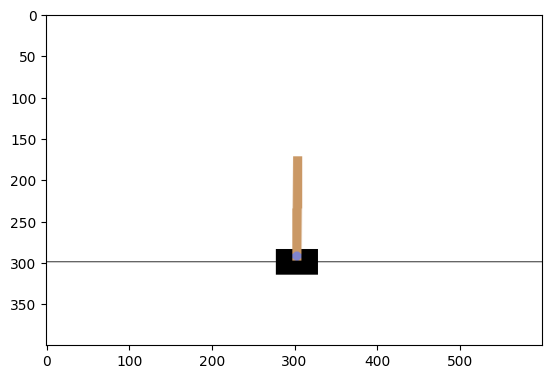

In [8]:
is_done = False
env = agent.env
obs = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
total_reward = 0
num_steps = 0
while not is_done:
    outputs = ort_model.run(None, {"obs": np.expand_dims(obs, axis=0).astype(np.float32)},)
    action = np.argmax(outputs[0])
    obs, reward, done, info = env.step(action)
    total_reward += reward
    num_steps += 1
    is_done = done
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    display.display(plt.gcf())    
    display.clear_output(wait=True)
print(total_reward, num_steps)
ipythondisplay.clear_output(wait=True)